<a href="https://colab.research.google.com/github/tonystark3110/ghost-free-shadow-removal/blob/main/myshadow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

environment


In [1]:
## init all the necessary models
!rm -rf *

!gdown https://drive.google.com/uc?id=1r6QD7lEM6UTMbnoxEQqTsK0k0B8XziC1
!gdown https://drive.google.com/uc?id=1rEIWWLwEpbZGPyFUc9jSIQr78ZeQy5eZ
!unzip srdplus-pretrained.zip && rm srdplus-pretrained.zip

!git clone  https://github.com/tonystark3110/ghost-free-shadow-removal
!cp ghost-free-shadow-removal/networks.py .

vgg19_path = 'imagenet-vgg-verydeep-19.mat'
pretrain_model_path = 'srdplus-pretrained/'
sample_path = 'ghost-free-shadow-removal/samples'

Downloading...
From: https://drive.google.com/uc?id=1r6QD7lEM6UTMbnoxEQqTsK0k0B8XziC1
To: /content/imagenet-vgg-verydeep-19.mat
535MB [00:05, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rEIWWLwEpbZGPyFUc9jSIQr78ZeQy5eZ
To: /content/srdplus-pretrained.zip
320MB [00:02, 123MB/s]
Archive:  srdplus-pretrained.zip
   creating: srdplus-pretrained/
  inflating: srdplus-pretrained/checkpoint  
  inflating: srdplus-pretrained/model_best.ckpt.data-00000-of-00001  
  inflating: srdplus-pretrained/model_best.ckpt.index  
  inflating: srdplus-pretrained/model_best.ckpt.meta  
Cloning into 'ghost-free-shadow-removal'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


loading pretrained models


In [2]:
# loaded pretrained model and build the calculate graph
%matplotlib inline
%tensorflow_version 1.x 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from networks import build_aggasatt_joint
tf.reset_default_graph()

with tf.variable_scope(tf.get_variable_scope()):
    input=tf.placeholder(tf.float32,shape=[None,None,None,3])
    shadow_free_image=build_aggasatt_joint(input,64,vgg19_path)

sess=tf.Session()
sess.run(tf.global_variables_initializer())
idtd_ckpt=tf.train.get_checkpoint_state(pretrain_model_path)
saver_restore=tf.train.Saver([var for var in tf.trainable_variables()])
print('loaded '+idtd_ckpt.model_checkpoint_path)
saver_restore.restore(sess,idtd_ckpt.model_checkpoint_path)

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

[i] Hypercolumn ON, building hypercolumn features ... 


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
loaded srdplus-pretrained/model_best.ckpt
INFO:tensorflow:Restoring parameters from srdplus-pretrained/model_best.ckpt


evaluation on srd data

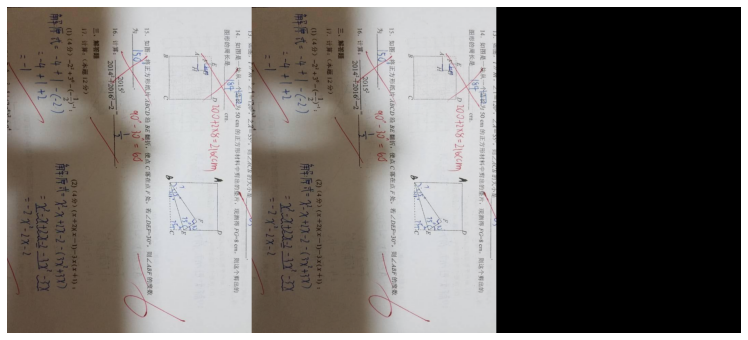

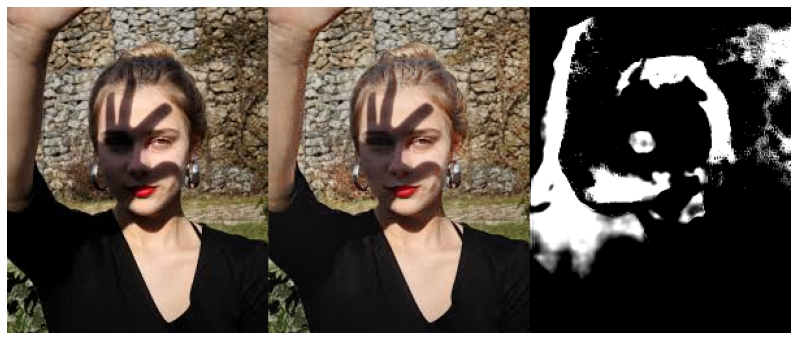

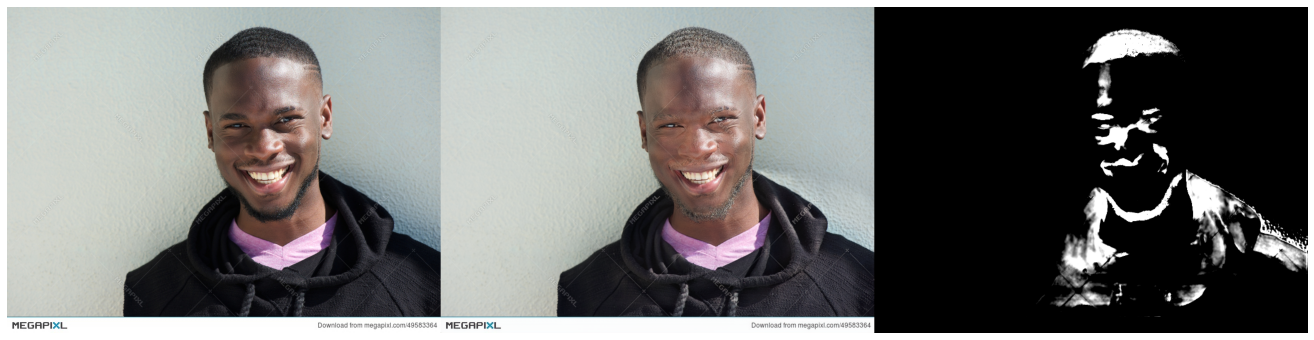

In [3]:
import os,cv2
# some samples results.
plt.rcParams["figure.figsize"] = (24,6)

for img_path in [os.path.join(sample_path,x) for x in os.listdir(sample_path) if '.jpg' in x ]:

    plt.figure()
    plt.axis('off')
    
    iminput=cv2.imread(img_path,-1)
    imoutput = sess.run(shadow_free_image,feed_dict={input:np.expand_dims(iminput/255.,axis=0)})

    ## imoutput[0] means the shadow removal results while imoutput[1] means the shadow detection results.
    imremoval = np.uint8(np.squeeze(np.minimum(np.maximum(imoutput[0],0.0),1.0))*255.0)
    immask = np.uint8(np.squeeze(np.minimum(np.maximum(imoutput[1],0.0),1.0))*255.0)
    imcompare = np.concatenate([iminput,imremoval,np.repeat(np.expand_dims(immask,axis=2),3,2)],axis=1)

    # bgr->rgb
    plt.imshow(imcompare[...,::-1])
    plt.show()

test samples from web

In [ ]:
# get image from web.
import requests
from io import BytesIO
from PIL import Image

plt.rcParams["figure.figsize"] = (24,6)
# images from google photo
# [you can replace the url with our own data for testing!]
urls = [
'http://thumbs.dreamstime.com/b/%E7%9F%B3%E5%A4%B4%E9%9B%95%E5%88%BB%E4%BA%86%E8%87%AA%E7%84%B6%E8%B7%AF%E7%BA%B9%E7%90%86%EF%BC%8C%E4%BB%8E%E9%B9%85%E5%8D%B5%E7%9F%B3%E5%A4%A7%E8%80%81%E5%8F%A4%E8%80%81%E9%94%90%E8%A7%92%E7%9A%84%E7%9F%B3%E5%A4%B4%E7%9A%84%E5%A2%99%E5%A3%81%E6%9C%89%E9%95%87%E5%8E%8B%E7%9A%84%E5%9C%A8%E9%98%B4%E5%BD%B1-th-121672690.jpg',
'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTSPlz6UtG4nmaEU1rSepVvvmCo5mZuaR9joQ&usqp=CAU',
'https://ak.picdn.net/offset/photos/5e99f11dd164c0404ea4d364/medium/offset_929329.jpg',
'http://thumbs.dreamstime.com/b/%E5%A4%A7%E6%A0%91%E6%9E%9D%E9%98%B4%E5%BD%B1%E7%9A%84%E6%8A%BD%E8%B1%A1%E8%87%AA%E7%84%B6%E6%A0%B7%E5%BC%8F%E5%9C%A8%E6%B5%85%E7%81%B0%E8%89%B2%E7%9A%84%E5%9D%9A%E7%A1%AC%E7%9F%B3%E6%B8%A3%E5%87%9D%E7%BB%93%E9%9D%A2%E8%83%8C%E6%99%AF%E5%9C%B0%E6%9D%BF%E4%B8%8A%E7%9A%84%E5%9C%A8%E5%A5%BD%E6%97%A5%E5%AD%90-129809634.jpg'
]

for url in urls:
  r = requests.get(url)
  # pil->numpy->bgr
  iminput = np.asarray(Image.open(BytesIO(r.content)))[...,::-1]
  imoutput = sess.run(shadow_free_image,feed_dict={input:np.expand_dims(iminput/255.,axis=0)})

  plt.figure()
  plt.axis('off')
  imoutput = np.uint8(np.squeeze(np.minimum(np.maximum(imoutput[0],0.0),1.0))*255.0)
  imcompare = np.concatenate([iminput,imoutput],axis=1)
  # bgr->rgb
  plt.imshow(imcompare[...,::-1])
  plt.show()